<a href="https://colab.research.google.com/github/MooyeongJoo/maxwell1/blob/master/week12_nsmc_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

from konlpy.tag import Okt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score



In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/naver_movie_train.txt", sep="\t")
df = df.dropna(subset=['document']).drop_duplicates(['document']).reset_index(drop=True)

df['token_len'] = df['document'].apply(lambda x: len(str(x).split()))
sampled_df = df.sort_values(by='token_len', ascending=False).head(3000).reset_index(drop=True)
print(f"샘플링된 데이터 개수: {len(sampled_df)}")

sampled_df['document'] = sampled_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
sampled_df['document'] = sampled_df['document'].str.strip().str.lower()

sampled_df.head()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()

def tokenize_and_filter(sentence):
    tokens = okt.morphs(sentence, stem=True)
    return [t for t in tokens if t not in stopwords and len(t) > 1]

token_okt = [tokenize_and_filter(s) for s in sampled_df['document']]

샘플링된 데이터 개수: 3000


In [ ]:
df.head()

,id,document,label,token_len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,5
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,4
2,10265843,너무재밓었다그래서보는것을추천한다,0,1
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,6
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,11


In [ ]:
df.columns

Index(['id', 'document', 'label', 'token_len'], dtype='object')

In [ ]:
df2 = pd.DataFrame(token_okt)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,민좆,파쇼,쌕기,종교,같이,깔다,수준,보솤,ㅋㅋㅋㅋㅋ,미군,...,None,None,None,None,None,None,None,None,None,None
1,정유미,정준영,부부,막둥이,부부,보다,윤한,부부,나오다,바로,...,부부,가다,제일,없다,None,None,None,None,None,None
2,측정,영화,당신,마음,아직,여리다,에게,상처,주지,당신,...,None,None,None,None,None,None,None,None,None,None
3,황당하다,소재,전개,쓰레기,같다,스토리,수준,초월,정말,어느,...,None,None,None,None,None,None,None,None,None,None
4,남자,아비,라면,김윤진,보다,있다,어미,아들,입장,라면,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_okt)
sequences = tokenizer.texts_to_sequences(token_okt)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(vocab_size)

11684


In [ ]:
# 8. 패딩 길이 결정을 위한 시퀀스 길이 분포 확인
sequence_lengths = [len(s) for s in sequences]
print(f"최대 시퀀스 길이 (Okt() 토큰 기준): {max(sequence_lengths)}")
print(f"평균 시퀀스 길이 (Okt() 토큰 기준): {np.mean(sequence_lengths):.0f}")

최대 시퀀스 길이 (Okt() 토큰 기준): 41
평균 시퀀스 길이 (Okt() 토큰 기준): 31


In [ ]:
pad_len = 40
padded_sequences = pad_sequences(sequences, maxlen=pad_len,padding='pre')

print(f"\n패딩된 시퀀스 shape: {padded_sequences.shape}")
print(f"패딩된 시퀀스 예시 (첫 번째 리뷰): {padded_sequences[0]}")


패딩된 시퀀스 shape: (3000, 40)
패딩된 시퀀스 예시 (첫 번째 리뷰): [   0    0    0    0    0    0    0    0    0    0 4110 5979 4111  717
  201  585  106 5980 4112 1924 1557  209  223  616  148 5981  114  255
 1924   68 1925    3 5982 2213 5983  543    4 4110 1114 4113]


In [ ]:
padded_sequences.dtype

dtype('int32')

In [ ]:
#sequences = np.array(sequences)
X = padded_sequences[:,:-1]
y = padded_sequences[:,-1]

y = to_categorical(y, num_classes=vocab_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# 3. 실험 함수 정의
embedding_dim = 64
hidden_units = 64
kernel_size =3

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=hidden_units, kernel_size=kernel_size, activation='tanh'),
    GlobalMaxPooling1D(),
    Dense(vocab_size, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

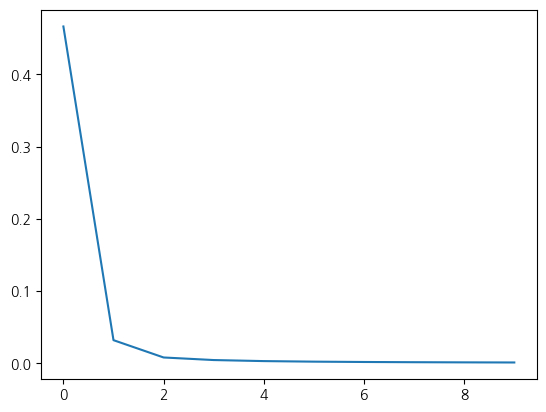

In [ ]:
plt.plot(history.history['loss'])